In [1]:
import os
os.environ['THEANO_FLAGS']='device=gpu'

import subprocess
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

from utils import load_data

#go to working directory
#work_dir='/nagyvinyok/adat84/sotejedlik/ribli/mhc'
work_dir='/mnt/Data1/ribli/mhc/'
subprocess.call(['mkdir',work_dir])
os.chdir(work_dir)

In [2]:
x,y=load_data(hla_representation='one-hot',seq_representation='blosum')

Reading from file...
Creating representation...
Using  83751 data points
Done, It took: 3.46999716759 s


### Create functions for cross validation

In [7]:
#create a very simple deepish model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping

def get_model(input_dim):
    """Creates Keras model needed."""
    model = Sequential()
    model.add(Dense(1024, input_dim=input_dim,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model


def fit_predict_model(get_model,X_train,y_train,X_test,
                      validation_split=0.1,patience=10,nb_epoch=100):
    """Fit model on train test set with early stopping."""
    #get model
    model=None
    model=get_model(X_train.shape[1])
    
    #callbacks
    best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=1)
    early_stop=EarlyStopping(patience=patience,verbose=1)

    #train it
    callb_hist=model.fit(X_train,y_train,nb_epoch = nb_epoch,
                            validation_split=validation_split,verbose=1,
                            callbacks=[best_model,early_stop])
    #predict
    model.load_weights('best_model')
    y_pred_test=model.predict(X_test).ravel()
    
    return y_pred_test


from sklearn.cross_validation import KFold
def cv_pred(get_model,x,y):
    """Evaluate model with cross validation."""
    #res
    y_pred=np.zeros(len(y))
    #folds
    for train_index,test_index in KFold(len(x),n_folds=3):
        #data split
        x_train,y_train,x_test=x[train_index],y[train_index],x[test_index]
        #fit predict
        y_pred[test_index]=fit_predict_model(get_model,x_train,y_train,x_test)
    return y_pred

In [8]:
y_pred=cv_pred(get_model,x,y)

Train on 50250 samples, validate on 5584 samples
Epoch 1/100
50250/50250 [==============================] - 2s - loss: 2.0928 - val_loss: 1.5909
Epoch 00000: val_loss improved from inf to 1.59092, saving model to best_model
Epoch 2/100
50250/50250 [==============================] - 2s - loss: 1.4820 - val_loss: 1.4685
Epoch 00001: val_loss improved from 1.59092 to 1.46851, saving model to best_model
Epoch 3/100
50250/50250 [==============================] - 2s - loss: 1.4171 - val_loss: 1.4281
Epoch 00002: val_loss improved from 1.46851 to 1.42811, saving model to best_model
Epoch 4/100
50250/50250 [==============================] - 2s - loss: 1.3587 - val_loss: 1.3554
Epoch 00003: val_loss improved from 1.42811 to 1.35542, saving model to best_model
Epoch 5/100
50250/50250 [==============================] - 2s - loss: 1.3044 - val_loss: 1.3814
Epoch 00004: val_loss did not improve
Epoch 6/100
50250/50250 [==============================] - 2s - loss: 1.2592 - val_loss: 1.2749
Epoch 000

Correlation: (0.69813183827334446, 0.0)


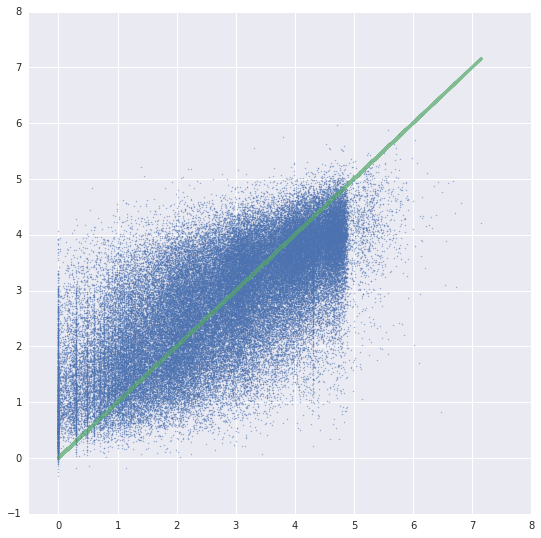

In [9]:
# check correlation
plt.figure(figsize=(9,9))
plt.plot(y,y_pred,'.',ms=3,alpha=0.5)
plt.plot(y,y,lw=3,alpha=0.7)
plt.xlim(xmin=-0.5)
from scipy.stats import pearsonr
print 'Correlation:',pearsonr(y,y_pred)

### Error depending on the length of peptid

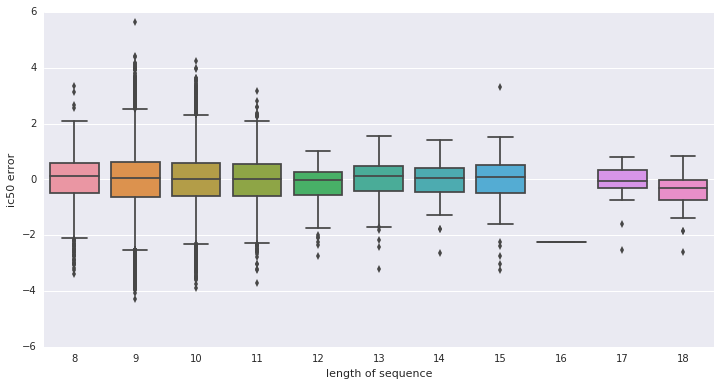

In [10]:
leng=x[:,-1]
plt.figure(figsize=(12,6))
sns.boxplot(leng,y-y_pred)
plt.xlabel('length of sequence')
dump=plt.ylabel('ic50 error')